## import data

In [1]:
!pip install lightgbm

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [3]:
train_data = pd.read_csv("data/train_data.csv")

In [4]:
train_data.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


## Visualize data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# データの統計量を表示
print("\n数値特徴量の基本統計量:")
print(train_data.describe())

# カテゴリ変数のユニーク値と頻度を確認
print("\nカテゴリ変数のユニーク値:")
for col in train_data.select_dtypes(include='object').columns:
    print(f"{col}: {train_data[col].nunique()} 個")
    print(train_data[col].value_counts().head())
    print()


数値特徴量の基本統計量:
       SeniorCitizen       tenure  MonthlyCharges
count    5634.000000  5634.000000     5634.000000
mean        0.160809    32.373092       64.864253
std         0.367388    24.424539       30.089324
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.750000
50%         0.000000    29.000000       70.525000
75%         0.000000    55.000000       89.937500
max         1.000000    72.000000      118.600000

カテゴリ変数のユニーク値:
customerID: 5634 個
customerID
4795-UXVCJ    1
4223-BKEOR    1
2876-GZYZC    1
9365-SRSZE    1
3137-NYQQI    1
Name: count, dtype: int64

gender: 2 個
gender
Male      2887
Female    2747
Name: count, dtype: int64

Partner: 2 個
Partner
No     2904
Yes    2730
Name: count, dtype: int64

Dependents: 2 個
Dependents
No     3951
Yes    1683
Name: count, dtype: int64

PhoneService: 2 個
PhoneService
Yes    5082
No      552
Name: count, dtype: int64

MultipleLines: 3 個
MultipleLines
No                  2685
Yes               


数値特徴量の分布:


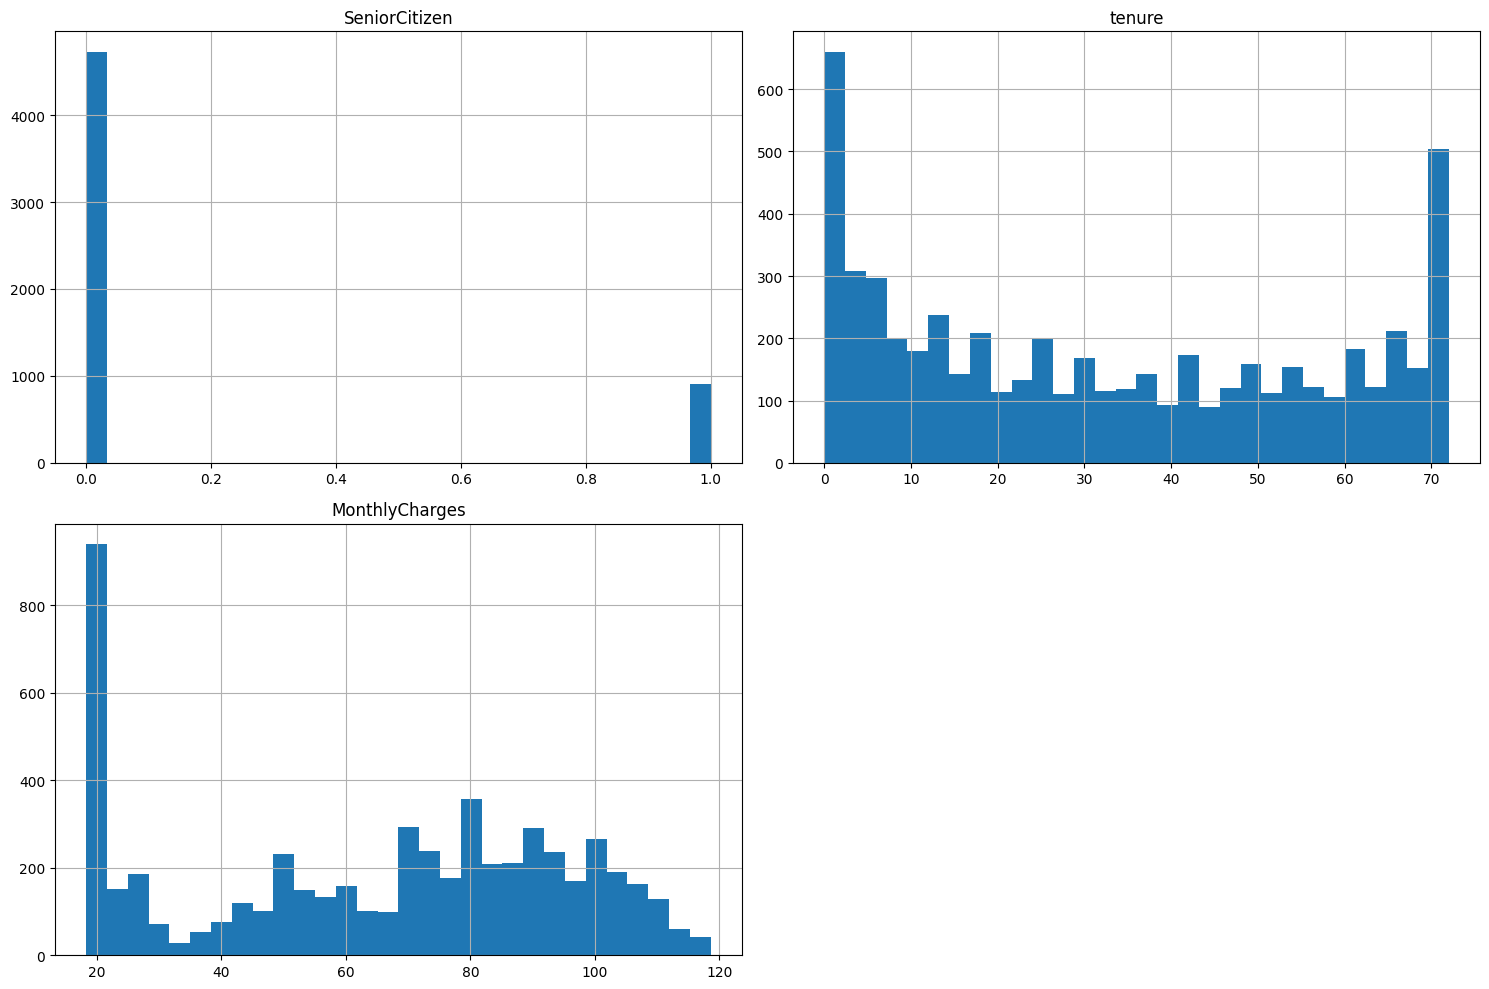

In [16]:
# 数値特徴量のヒストグラムを表示
print("\n数値特徴量の分布:")
numeric_data = train_data.select_dtypes(include=['number'])

# 数値特徴量のヒストグラム
numeric_data.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()


カテゴリ特徴量の分布:


/tmp/ipykernel_3056/555354676.py:12: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  numeric_data.hist(bins=30, ax=ax)
/tmp/ipykernel_3056/555354676.py:20: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


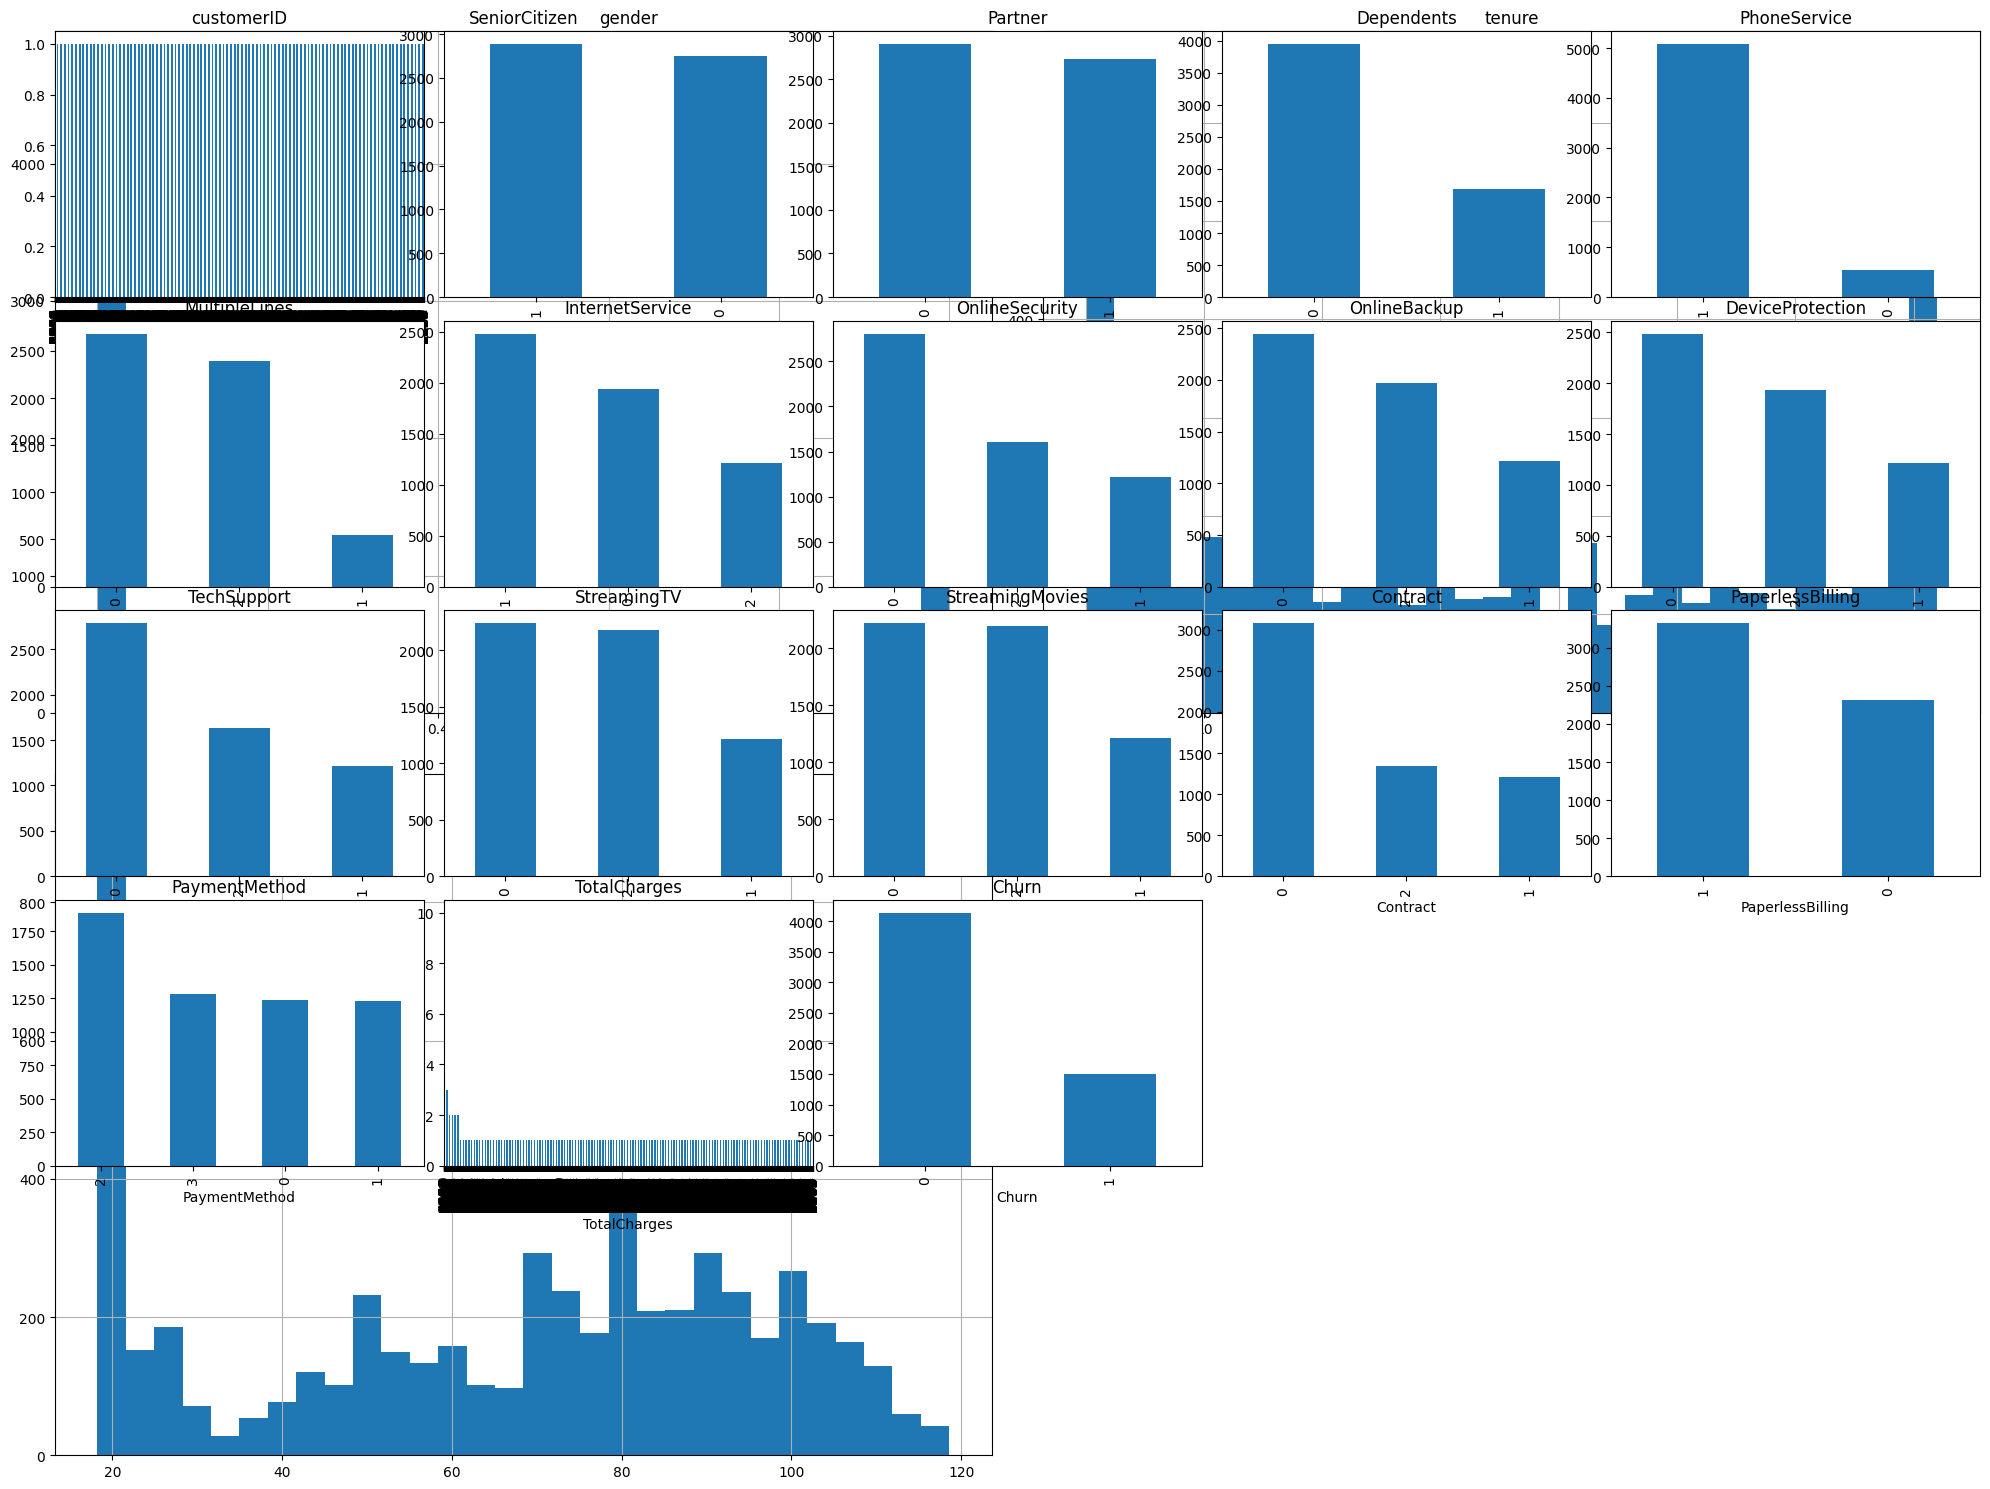

In [17]:
# カテゴリ特徴量のエンコーディングと分布
print("\nカテゴリ特徴量の分布:")
categorical_data = train_data.select_dtypes(include=['object'])

# ラベルエンコーディングを実行
encoded_data = categorical_data.apply(LabelEncoder().fit_transform)

# プロットの作成 (数値特徴量とカテゴリ特徴量を1つの枠に収める)
fig, ax = plt.subplots(figsize=(20, 15))

# 数値特徴量をヒストグラムで表示
numeric_data.hist(bins=30, ax=ax)
plt.tight_layout()

# カテゴリ変数の分布を棒グラフとして表示
for i, column in enumerate(encoded_data.columns):
    ax = plt.subplot(5, 5, i + 1)
    encoded_data[column].value_counts().plot(kind='bar', ax=ax, title=f'{column}')

plt.tight_layout()
plt.show()

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency

# カテゴリ変数同士の相関をCramér's Vで計算
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

# 相関行列の作成（カテゴリ変数の処理を含む）
def compute_corr(X, categorical_cols):
    # カテゴリ変数のエンコーディング
    le = LabelEncoder()
    for col in categorical_cols:
        X[col] = le.fit_transform(X[col])
    
    # 数値データの相関行列
    corr = X.corr()

    # カテゴリ変数同士の相関を計算（Cramér's V）
    cramers_v_matrix = pd.DataFrame(np.zeros((len(categorical_cols), len(categorical_cols))),
                                    columns=categorical_cols, index=categorical_cols)
    
    for i, col1 in enumerate(categorical_cols):
        for j, col2 in enumerate(categorical_cols):
            if i < j:
                cramers_v_matrix.loc[col1, col2] = cramers_v(X[col1], X[col2])
                cramers_v_matrix.loc[col2, col1] = cramers_v_matrix.loc[col1, col2]
    
    return corr, cramers_v_matrix

# 目標変数 'Churn' と特徴量を分ける
X = train_data.drop(columns=['customerID'])  # 'customerID' は削除（個別識別子なので予測に使わない）

# 特定の特徴量の影響を強める工夫（例: 'tenure'）
X['tenure_squared'] = X['tenure'] ** 2
X['tenure_log'] = np.log1p(X['tenure'])
X['tenure_MonthlyCharges'] = X['tenure'] * X['MonthlyCharges']

X['MonthlyCharges_squared'] = X['MonthlyCharges'] ** 2
X['MonthlyCharges_log'] = np.log1p(X['MonthlyCharges'])

In [32]:
print(X.columns)

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'tenure_squared', 'tenure_log', 'tenure_MonthlyCharges',
       'MonthlyCharges_squared', 'MonthlyCharges_log'],
      dtype='object')


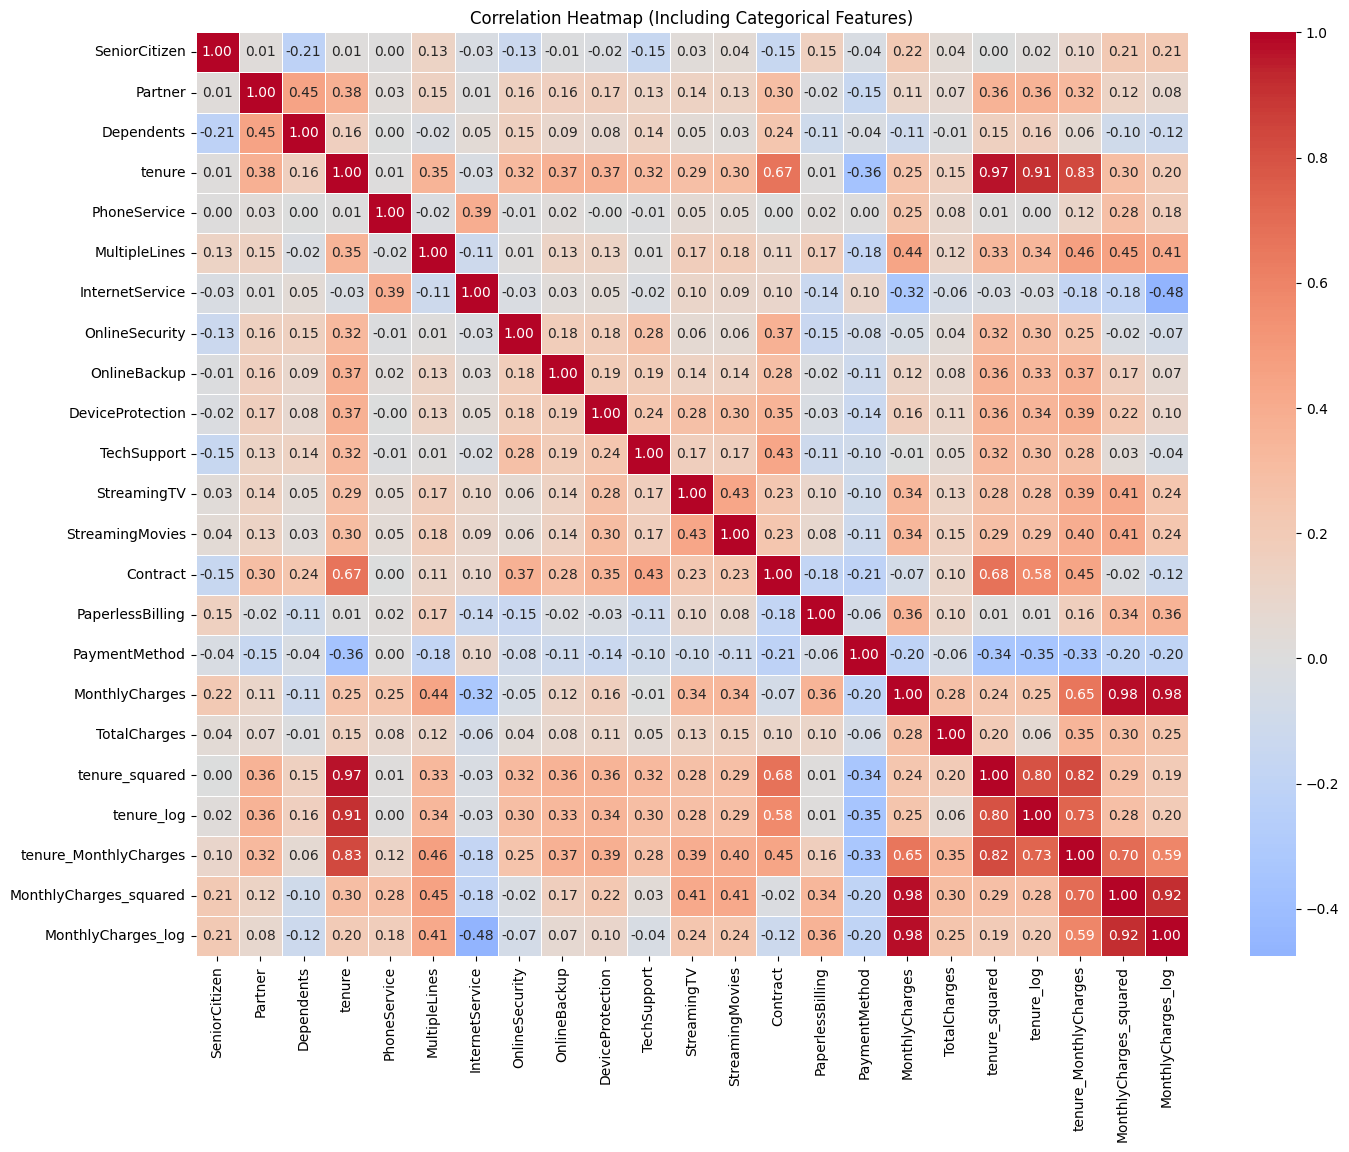

In [33]:

# カテゴリ変数のカラムを取得
categorical_cols = X.select_dtypes(include=['object']).columns

# 相関を計算
corr, cramers_v_matrix = compute_corr(X, categorical_cols)

# 数値データの相関行列とカテゴリ変数同士のCramér's Vを結合
full_corr = pd.concat([corr, cramers_v_matrix], axis=1, join='outer')

# 相関行列をヒートマップで可視化
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Heatmap (Including Categorical Features)')
plt.show()

## データの前処理

In [23]:
train_data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## モデル開発

In [31]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

column_list = ['SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

# 目標変数 'Churn' と特徴量を分ける
X = X[column_list]
y = train_data['Churn']

# 上で行っていた特徴量エンジニアリング
# 特定の特徴量の影響を強める工夫（例: 'tenure'）
X['tenure_squared'] = X['tenure'] ** 2
X['tenure_log'] = np.log1p(X['tenure'])
X['tenure_MonthlyCharges'] = X['tenure'] * X['MonthlyCharges']
X['MonthlyCharges_squared'] = X['MonthlyCharges'] ** 2
X['MonthlyCharges_log'] = np.log1p(X['MonthlyCharges'])
print(X.columns)

# ラベルエンコーディング（カテゴリ変数の処理）
le = LabelEncoder()

# 'Churn'列の 'Yes'/'No' を 1/0 に変換
y = le.fit_transform(y)

# 'TotalCharges'が文字列の場合、数値に変換
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

# カテゴリ変数のカラムを取得
categorical_cols = X.select_dtypes(include=['object']).columns

# カテゴリ変数をラベルエンコード（数値に変換）
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# StratifiedKFoldを使用して、クロスバリデーションを実行
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# LightGBMのモデルを作成
lgb_model = lgb.LGBMClassifier()

# パラメータグリッドを定義（チューニングしたいハイパーパラメータを指定）
param_grid = {
    'num_leaves': [20],         # 木の葉の数
    'max_depth': [10],           # 最大深さ
    'learning_rate': [0.05],   # 学習率
    'n_estimators': [200],          # 木の数
    'subsample': [0.8],             # サブサンプリングの割合
    'colsample_bytree': [0.8]       # 木ごとの特徴量サブサンプリング
}

# GridSearchCVを使用してハイパーパラメータをチューニング
grid_search = GridSearchCV(estimator=lgb_model, param_grid=param_grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=1)

# グリッドサーチを実行
grid_search.fit(X, y)

# 最良のパラメータを表示
print(f"最良のパラメータ: {grid_search.best_params_}")

# 最良のモデルで予測
best_model = grid_search.best_estimator_

# 検証データを使って予測（再度分割したデータを使用することができます）
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_model.predict(X_val)

# 精度の評価
accuracy = accuracy_score(y_val, y_pred)
print(f"最良モデルの検証データに対する精度: {accuracy:.4f}")

Index(['SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'tenure_squared', 'tenure_log', 'tenure_MonthlyCharges',
       'MonthlyCharges_squared', 'MonthlyCharges_log'],
      dtype='object')
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Info] Number of positive: 1197, number of negative: 3310
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1535
[LightGBM] [Info] Number of data points in the train set: 4507, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265587 -> 

In [38]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 必要なライブラリのインポート
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# 1. データの読込
data_path = "data/train_data.csv"
df = pd.read_csv(data_path)

print("データの形状:", df.shape)
print("カラム一覧:", df.columns.tolist())
print("データの先頭5行:\n", df.head())

# 2. 目的変数と説明変数の指定
# ここでは目的変数のカラムを 'cancel' と仮定しています
target_col = 'Churn'
if target_col not in df.columns:
    print("対象カラム 'cancel' が存在しないため、最後のカラムを目的変数として採用します。")
    target_col = df.columns[-1]

X = df.drop(columns=[target_col])
y = df[target_col]

# 3. 前処理
# 3-1. 欠損値補完
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        # 数値データは中央値で補完
        X[col].fillna(X[col].median(), inplace=True)
    else:
        # カテゴリ変数は最頻値で補完
        X[col].fillna(X[col].mode()[0], inplace=True)

# 3-2. カテゴリ変数のエンコーディング（LabelEncoding）
cat_feats = X.select_dtypes(include=['object']).columns.tolist()
for col in cat_feats:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# 4. 学習データと検証データへの分割（8:2, stratify使用）
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 5. モデルの学習と評価

# 5-1. ロジスティック回帰
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_pred_prob = lr_model.predict_proba(X_val)[:, 1]
lr_auc = roc_auc_score(y_val, lr_pred_prob)
print("ロジスティック回帰の検証ROC AUC:", lr_auc)

# 5-2. ランダムフォレスト
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred_prob = rf_model.predict_proba(X_val)[:, 1]
rf_auc = roc_auc_score(y_val, rf_pred_prob)
print("ランダムフォレストの検証ROC AUC:", rf_auc)

# 5-3. LightGBM（初期モデル）
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train, 
              eval_set=[(X_val, y_val)], 
              eval_metric='auc')
lgb_pred_prob = lgb_model.predict_proba(X_val)[:, 1]
lgb_auc = roc_auc_score(y_val, lgb_pred_prob)
print("初期LightGBMの検証ROC AUC:", lgb_auc)

# 6. LightGBM のハイパーパラメータチューニング（GridSearchCV）
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
}

lgbm_tuned = LGBMClassifier(random_state=42)
grid = GridSearchCV(
    estimator=lgbm_tuned,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
)
grid.fit(X_train, y_train)

print("GridSearchCVによる最適パラメータ:", grid.best_params_)
print("交差検証での最高ROC AUC:", grid.best_score_)

# 7. 最適パラメータを用いた最終モデルの評価
best_model = grid.best_estimator_
best_pred_prob = best_model.predict_proba(X_val)[:, 1]
best_auc = roc_auc_score(y_val, best_pred_prob)
print("最適LightGBMの検証ROC AUC:", best_auc)


データの形状: (5634, 21)
カラム一覧: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']
データの先頭5行:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  4223-BKEOR  Female              0      No        Yes      21          Yes   
1  6035-RIIOM  Female              0      No         No      54          Yes   
2  3797-VTIDR    Male              0     Yes         No       1           No   
3  2568-BRGYX    Male              0      No         No       4          Yes   
4  2775-SEFEE    Male              0      No        Yes       0          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0                No             DSL            Yes  ...              Yes   
1     